In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
           
            nn.Conv2d(10, 10, 3), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
           
            nn.Conv2d(10, 10, 3), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
        
        )

        self.trans1 = nn.Sequential(
           
            nn.AvgPool2d(2, 2),  # 22x22 output - 11x11 RF 14x14

        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(10, 10, 3), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
            
            nn.Conv2d(10, 10, 3),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(10),
            
            
        )

        self.trans2 = nn.Sequential(
            
            nn.AvgPool2d(2, stride=2, padding=0)
        )
        self.fc = nn.Linear(10*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             910
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             910
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
        AvgPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             910
             ReLU-12             [-1, 10, 9, 9]               0
      BatchNorm2d-13             [-1, 10, 9, 9]              20
           Conv2d-14             [-1, 1

In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([                        
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [ ]:

model = Net().to(device)
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

for epoch in range(0, 15):
    print(f"Epoch {epoch}")
    
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
   
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0


loss=0.02779441885650158 batch_id=468: 100%|██████████| 469/469 [00:10<00:00, 42.82it/s]


Train set: Average loss: 0.0010, Accuracy: 57739/60000 (96.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9865/10000 (98.65%)

Epoch 1


loss=0.04704548045992851 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.27it/s]


Train set: Average loss: 0.0004, Accuracy: 59063/60000 (98.44%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9886/10000 (98.86%)

Epoch 2


loss=0.01673988811671734 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]


Train set: Average loss: 0.0003, Accuracy: 59292/60000 (98.82%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9895/10000 (98.95%)

Epoch 3


loss=0.0345219150185585 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.57it/s]


Train set: Average loss: 0.0003, Accuracy: 59337/60000 (98.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9895/10000 (98.95%)

Epoch 4


loss=0.021411888301372528 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.14it/s]


Train set: Average loss: 0.0002, Accuracy: 59406/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)

Epoch 5


loss=0.01662941463291645 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]


Train set: Average loss: 0.0002, Accuracy: 59419/60000 (99.03%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

Epoch 6


loss=0.06621386855840683 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.24it/s]


Train set: Average loss: 0.0002, Accuracy: 59461/60000 (99.10%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

Epoch 7


loss=0.008746642619371414 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.86it/s]


Train set: Average loss: 0.0002, Accuracy: 59536/60000 (99.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

Epoch 8


loss=0.009352699853479862 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]


Train set: Average loss: 0.0002, Accuracy: 59555/60000 (99.26%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

Epoch 9


loss=0.07684176415205002 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s]


Train set: Average loss: 0.0002, Accuracy: 59583/60000 (99.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9911/10000 (99.11%)

Epoch 10


loss=0.00300612929277122 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]


Train set: Average loss: 0.0002, Accuracy: 59576/60000 (99.29%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

Epoch 11


loss=0.0009461452136747539 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.00it/s]


Train set: Average loss: 0.0002, Accuracy: 59615/60000 (99.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

Epoch 12


loss=0.04866695776581764 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.98it/s]


Train set: Average loss: 0.0001, Accuracy: 59646/60000 (99.41%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

Epoch 13


loss=0.017056988552212715 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 42.24it/s]


Train set: Average loss: 0.0001, Accuracy: 59674/60000 (99.46%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9928/10000 (99.28%)

Epoch 14


loss=0.001780807040631771 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 41.37it/s]


Train set: Average loss: 0.0001, Accuracy: 59652/60000 (99.42%)




Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)



Text(0.5, 1.0, 'Loss per epoch')

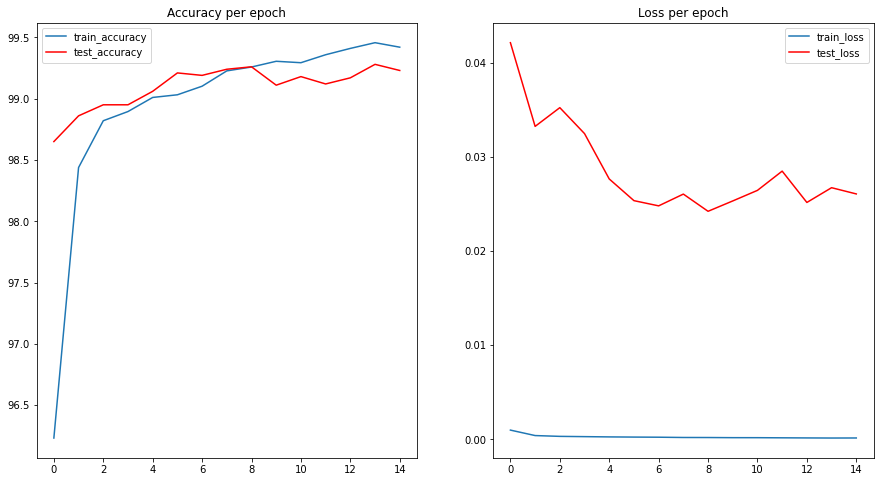

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

